In [1]:
import app.curve as curve
import app.calibration as c
import app.warp as w
import app.edges as e
import app.lane_finder as lf

import cv2
import matplotlib.pyplot as plt
import importlib
import numpy as np

from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
from IPython.display import HTML
%matplotlib inline

In [ ]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

calibrator = c.Camera_calibrator()
calibrator.initialize()
undist = calibrator.calibrate(img)
warped = w.warp(undist)
edges = e.Edges(warped)

_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
_ = edges.gradient_color_channel(220,255,0,space=cv2.COLOR_RGB2LUV)
_ = edges.gradient_color_channel(150,255,2,space=cv2.COLOR_RGB2LAB)



#gx = edges.gradient_x()

In [ ]:
importlib.reload(curve)
l_window = curve.CurveWindows(edges.combined, 430, margin=40, maxpix=2400)
r_window = curve.CurveWindows(edges.combined, 880, margin=40)

w1 = cv2.cvtColor(edges.combined, cv2.COLOR_GRAY2RGB)
w1 = w1*50

l_window.draw_rect(w1)
r_window.draw_rect(w1)

plt.figure(figsize=(20,10))
plt.imshow(w1)


In [ ]:
importlib.reload(curve)
w1 = cv2.cvtColor(edges.combined, cv2.COLOR_GRAY2RGB)
w1 = w1*40

left = curve.Curve(880)
left.curve_fit(edges.combined)
left.draw_curve(w1, thick=5)

right = curve.Curve(430)
right.curve_fit(edges.combined)
right.draw_curve(w1, thick=5)


plt.figure(figsize=(20,10))
plt.imshow(w1)

In [102]:
def generate_mask(warped):
    edges = e.Edges(warped)
    #_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
    #_ = edges.gradient_color_channel(225,255,0,space=cv2.COLOR_RGB2LUV)
    #_ = edges.gradient_color_channel(155,200,2,space=cv2.COLOR_RGB2LAB)
    
    # Good for challenge
    #_ = edges.gradient_color_channel(200,255,2,space=cv2.COLOR_RGB2HLS)
    ##_ = edges.gradient_color_channel(190,255,0,space=cv2.COLOR_RGB2LUV) # white
    #_ = edges.gradient_color_channel(220,255,0,space=cv2.COLOR_RGB2LUV) # white
    #_ = edges.gradient_color_channel(140,255,2,space=cv2.COLOR_RGB2LAB) # yellow
    ##_ = edges.gradient_color_inrange(180, 255, combine=True, space=cv2.COLOR_RGB2GRAY)

    #_ = edges.gradient_color_channel(200,255,2,space=cv2.COLOR_RGB2HLS)
    #_ = edges.gradient_color_channel(190,255,0,space=cv2.COLOR_RGB2LUV) # white
    
    #_ = edges.gradient_color_channel(250,255,0,space=cv2.COLOR_RGB2LUV) # white
    #_ = edges.gradient_color_channel(150,255,2,space=cv2.COLOR_RGB2LAB) # yellow
    
    #_ = edges.gradient_color_inrange(245, 255, combine=True, space=cv2.COLOR_RGB2GRAY)
    
    # videos made with this
    #_ = edges.gradient_color_channel(250,255,0,space=cv2.COLOR_RGB2LUV) # white
    #_ = edges.gradient_color_channel(140,255,2,space=cv2.COLOR_RGB2LAB) # yellow
    #_ = edges.gradient_color_inrange(245, 255, combine=True, space=cv2.COLOR_RGB2GRAY)
    
    yellow = edges.gradient_color_inrange((190,170,90), (220,200,120)), space=cv2.COLOR_RGB2BGR)
    white = edges.gradient_color_inrange((180,180, 180), (255,255,255)), space=cv2.COLOR_RGB2BGR)
    
    return edges.combined

def prepare_img(img):
    calibrator = c.Camera_calibrator()
    calibrator.initialize()
    undist = calibrator.calibrate(img)
    warped = w.warp(undist)
    return generate_mask(warped), warped

def get_base_points(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base, histogram

def equalize_color_hist(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    result = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    return result

def calc_curvature(curve):
    if curve.curve_valid_win is None:
        return 0
    if curve.curve_valid_win.points_x is None:
        return 0
    points_y = curve.curve_valid_win.points_y
    points_x = curve.curve_valid_win.points_x
    ym_per_pix = 30./720
    xm_per_pix = 3.7/700
    fit_cr = np.polyfit(points_y*ym_per_pix, points_x*xm_per_pix, 2)
    c_rad = ((1 + (2*fit_cr[0]*np.max(points_y) + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return c_rad

def calc_curvature_avg(l_curve, r_curve):
    l_curved = calc_curvature(l_curve)
    r_curved = calc_curvature(r_curve)
    c_avg = (l_curved + r_curved) / 2
    return c_avg

SyntaxError: invalid syntax (<ipython-input-102-c1c203290245>, line 27)

In [103]:
frame = 0
l_curve = None
r_curve = None
recheck_center = True

def handler():
    global frame
    global l_curve
    global r_curve
    global recheck_center
    
    frame = 0
    l_curve = None
    r_curve = None
    recheck_center = True

    def handle_frame(img):
        #img = equalize_color_hist(img)
        img_y, img_x, _ = img.shape
        midpoint = int(img_x/2)
        x_offset=10
        y_offset = 60
        global frame
        global l_curve
        global r_curve
        global recheck_center
        
        frame += 1
        mask, warped = prepare_img(img)
        leftx_base = rightx_base = 0
        if recheck_center is True:
            leftx_base, rightx_base, _ = get_base_points(mask)
            if l_curve is not None:
                l_curve.center= leftx_base
            if r_curve is not None:
                r_curve.center = rightx_base
            recheck_center = False
    
        if l_curve is None or r_curve is None:
            l_curve = curve.Curve(leftx_base, (0, midpoint), margin=80)
            r_curve = curve.Curve(rightx_base, (midpoint, img_x), margin=100)
        
        l_valid = l_curve.curve_fit(mask)
        r_valid = r_curve.curve_fit(mask)
    
        if l_valid is False or r_valid is False:
            recheck_center = True
    
        marked = np.zeros_like(warped)
        #l_curve.draw_curve(marked, thick=10)
        #r_curve.draw_curve(marked, thick=10)
        
        marked = lf.plot_lanes(img, l_curve.fit, r_curve.fit, warped.shape, fill=True)
    
        unwarped = w.unwarp(marked)
        final = cv2.addWeighted(img,0.7,unwarped,0.99,0)
        
        s_img = mask*255
        s_img = cv2.cvtColor(s_img, cv2.COLOR_GRAY2RGB)
        l_curve.curve_windows.draw_rect(s_img)
        r_curve.curve_windows.draw_rect(s_img)
        l_curve.draw_curve(s_img, thick=4)
        r_curve.draw_curve(s_img, thick=4)

        s_img_x, s_img_y = int((s_img.shape[1]/2)), int((s_img.shape[0]/2))
        s_img = cv2.resize(s_img, (s_img_y, s_img_y))
        final[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
      
        curvature = calc_curvature_avg(l_curve, r_curve)
    
        left_mean = l_curve.fit_avg(warped.shape[0])
        right_mean = r_curve.fit_avg(warped.shape[0])
        position = (right_mean+left_mean)/2
        dist_from_center = warped.shape[1]/2-position
        pos = 'left'
        if dist_from_center < 0:
            pos = 'right'
        dist= 3.7/700 * abs(dist_from_center)
        #print('left {} right {} position {} -center {} dist {}'.format(left_mean, right_mean, position, dist_from_center, dist))
        txt_dist = 'Vehicle is {0:.2g}m {1} from the center radius of curvature {2:.0f}m'.format(dist, pos, curvature)
        cv2.putText(final,txt_dist, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 2)
        #if frame % 10 == 0:
        #    recheck_center = True
        
        return final
    return handle_frame


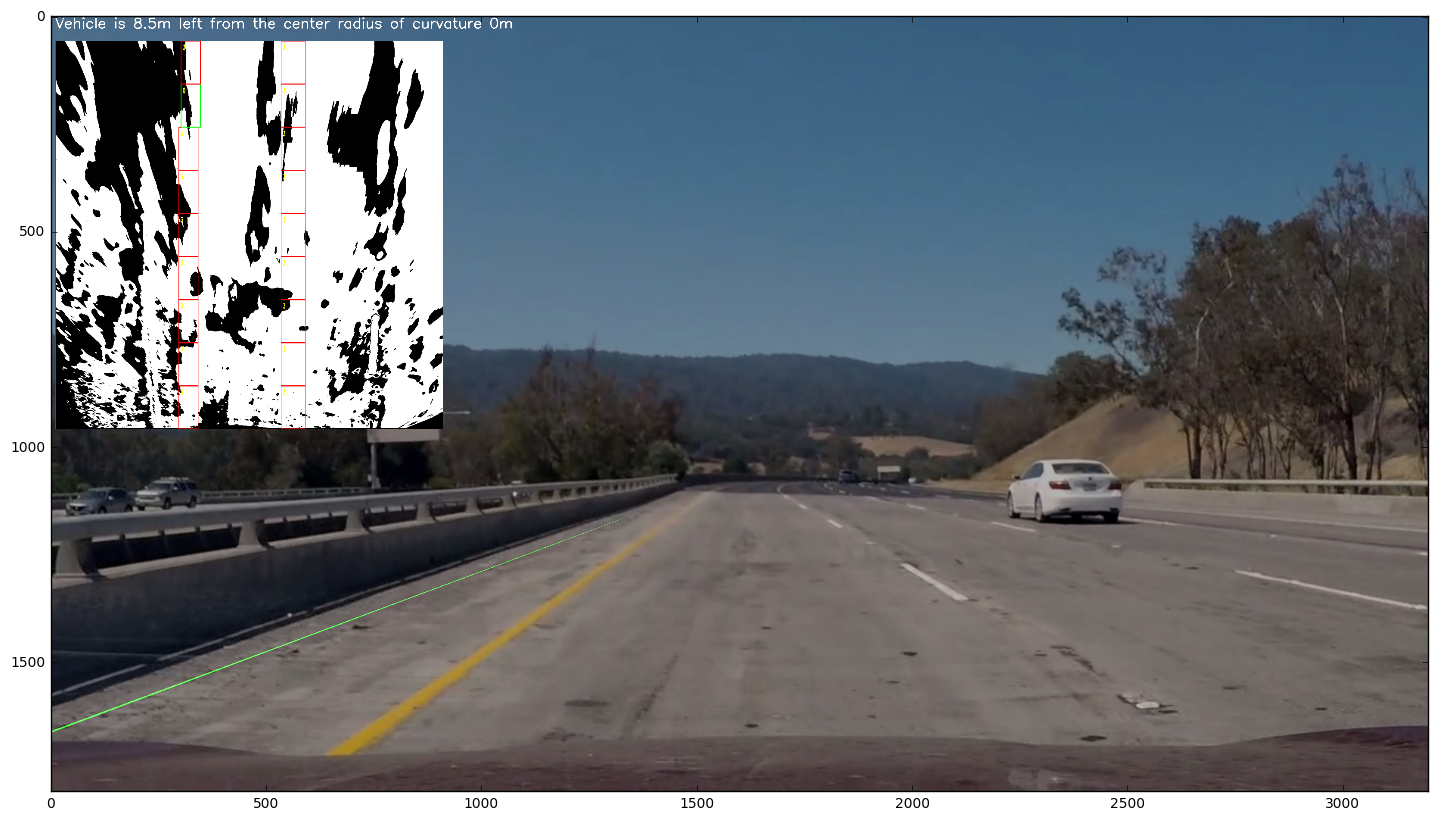

In [104]:
importlib.reload(curve)
img = cv2.imread('extra/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processor = handler()
fr = processor(img)
plt.figure(figsize=(20,10))
plt.imshow(fr)

In [83]:
processor = handler()
white_output = 'challenge_video_out_simple.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out_simple.mp4
[MoviePy] Writing video challenge_video_out_simple.mp4


100%|██████████| 485/485 [05:00<00:00,  1.63it/s]     | 1/485 [00:00<05:14,  1.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out_simple.mp4 

CPU times: user 6min 21s, sys: 1.36 s, total: 6min 22s
Wall time: 5min 1s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
importlib.reload(curve)

In [ ]:
processor = handler()
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)

In [4]:
processor = handler()
white_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4


100%|█████████▉| 1199/1200 [13:11<00:00,  1.53it/s]    | 1/1200 [00:00<13:06,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

CPU times: user 19min 16s, sys: 9.92 s, total: 19min 26s
Wall time: 13min 12s


In [ ]:
importlib.reload(curve)
processor = handler()
white_output = 'challenge_video_out1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)
processor = handler()
white_output = 'project_video_out1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)
processor = handler()
white_output = 'harder_challenge_video_out1.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(processor)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
'{0:.3g}'.format(3.132423)

In [ ]:
math.roun